### Volume Fraction Profiles from SF-SCF Calculations

We employ a two-gradient Scheutjens-Fleer Self-Consistent Field (SF-SCF) method in cylindrical geometry.  
A full description is provided in Supplementary Note 3 of the original work.  
Here we present technical details for the purposes of reproducibility.  

We do not discuss the generation of input files, as this is extensively covered in the Namics/SFbox manual.  
However, we provide an example below.  

Each grafted chain is anchored by a monomer segment pinned to the pore surface.  
Pinned monomers are constrained to the inner cylindrical surface (constant radius).  
This allows them to slide freely along the **z-axis** (one less degree of freedom than a free segment).  
To prevent such lateral motion, the pore is divided along its **z-axis** into discrete slices (rings).  
Each slice defines its own grafting site, thereby immobilizing pinned segments within that slice.  
For each slice, a fraction of chains is grafted to the wall, so that the total polymer quantity is distributed evenly along the pore length and the grafting density is conserved.  

Example input snippet from `SCF/empty_pore_input.in`:

```text
mol:pol0:composition:(P0)1(P)299
mol:pol0:freedom:restricted
mol:pol0:theta:980.1769079200155
mon:P0:freedom:pinned
mon:P0:pinned_range:26,121;26,121
...
mol:pol51:composition:(P0)1(P)299
mol:pol51:freedom:restricted
mol:pol51:theta:980.1769079200155
mon:P51:freedom:pinned
mon:P51:pinned_range:26,172;26,172
```

The numerical SF-SCF algorithm then minimizes the excess Helmholtz free energy subject to the incompressibility constraint, yielding the **equilibrium volume fraction distribution** of polymer segments originating from each grafting slice.  
- In our system, the pore has a length of 52 lattice units, with slices labeled from $z = -26$ to z = $+25$.  
- Each slice corresponds to one set of grafted chains, allowing us to examine how different grafting positions contribute to the overall polymer distribution.  
- The results are stored in the Namics/SFbox output files, which provide the local volume fractions $\phi(r,z)$ for every grafting site.  


The code below loads these results, and plots the **polymer volume fraction profiles**  with an interactive slider.  
An interactive **slider** lets you scroll through the slices along the $z$-axis, visualizing how chains grafted at different axial positions distribute inside the pore.

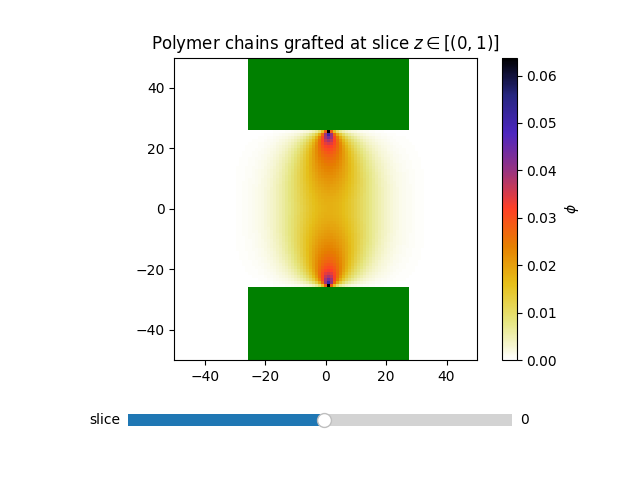

In [33]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.read_namics_output import extract_volume_fractions_per_grafting_range, create_walls
from src.utils import mirror_extend
from src.make_plot import plot_with_slider, plot_grid

raw = pd.read_table("SCF/output/empty_pore_input.pro", index_col=False)
R, Z, Phis = extract_volume_fractions_per_grafting_range(raw)
pore_radius = 26
pore_length = 52
walls = create_walls(len(R), len(Z), pore_radius, pore_length).T
fig, ax = plot_with_slider(
    Z, 
    np.concatenate((-R[::-1], R)), 
    #for readability of the plot and consistent formatting with the original work we plot the mirrored array along z axis
    mirror_extend(Phis.transpose(0,2,1), axis=1), 
    fix_clim=True, 
    walls = mirror_extend(walls, axis = 0),
    xlim = (-50,50),
    ylim = (-50,50)
)

### Calculating the Total Polymer Volume Fraction

The premise of our method is to use the polymer volume fraction of a brush **unperturbed by colloid particles**.  
To obtain this, we must sum the volume fractions of all polymer chains grafted along the pore.  

This can be done in two equivalent ways:

1. **Per slice:** summing the volume fraction of all chains grafted at each slice along the $z$-axis.  
2. **Per monomer type:** summing the volume fraction contributions of every chain segment type in the polymer brush.  

Both datasets are available in the Namics/SFbox output files.  
Here, we use the **per-slice method**.

The calculation is expressed as:

$$
\phi_n(r,z) = \sum_{s=1}^{N} \phi_s(r,z)
$$

where  
- $s$ is the index of a chain segment ($s = 1, \dots, N$),  
- $\phi_s(r,z)$ is the volume fraction of segment $s$,  
- $\phi_n(r,z)$ is the total volume fraction of a chain grafted at slice $n$.  

Finally, summing over all grafting slices yields the overall polymer volume fraction:

$$
\phi(r,z) = \sum_{n=0}^{L} \phi_n(r,z)
$$

where $n$ is the slice index along the pore length $L$.


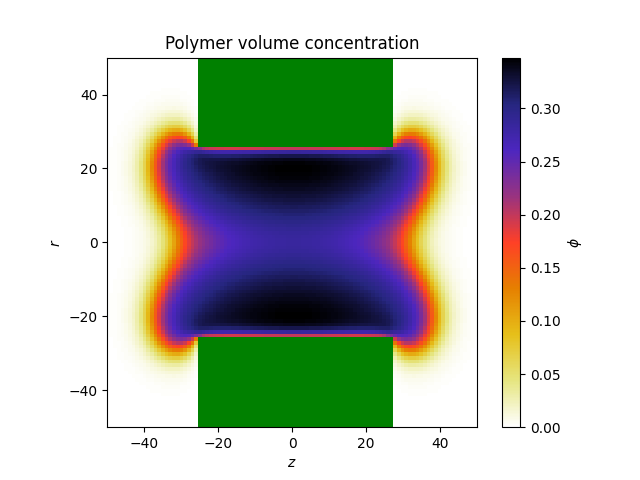

In [13]:
phi_0 = np.sum(Phis, axis = 0).T

fig, ax = plot_grid(
    Z, 
    np.concatenate((-R[::-1], R)), 
    mirror_extend(phi_0, axis=0), 
    walls = mirror_extend(walls, axis = 0),
    xlim = (-50,50),
    ylim = (-50,50)
)

### Modeling Colloid Insertion and Traversal

Minor modifications to the input files allow us to model the insertion of a **cylindrical colloid particle** into the pore, and ultimately its traversal along the central axis.  
The key changes are introduced in `SCF/colloid_traversing_pore.in`.

```text
mon:P:chi_C:0.0
mon:C:freedom:frozen
mon:C:frozen_range:1,18;3,23
...
start
mon:C:frozen_range:1,64;3,69
start
mon:C:frozen_range:1,65;3,70
start
mon:C:frozen_range:1,66;3,71
...


Here, the frozen range specifies lattice cells that are impermeable to the polymer, effectively modeling the colloid particle.
Sequential calculations with a rolling frozen range correspond to the particle moving stepwise along the pore axis.

In this example, we model an inert colloid, characterized by a polymer–colloid interaction parameter $\chi_\text{PC} = 0$



In [14]:
# Here will be disturbed volume fraction profiles plotted

In [15]:
#temporary here until the data is not recomputed with namics
computed_in_main = pd.read_pickle("reference_table.pkl")
conds = dict(N=300, chi_PC=0, chi_PS=0.6, r=26, s=52, sigma = 0.02, ph=6, pw = 6)
insertion_free_energy_data = computed_in_main[computed_in_main[list(conds)].eq(pd.Series(conds)).all(axis=1)][["chi_PC", "chi_PW", "ph", "pw", "pc", "free_energy"]].sort_values(by = "pc")
insertion_free_energy_data


,chi_PC,chi_PW,ph,pw,pc,free_energy
4537,0.0,0.0,6,6,-126,0.000
4541,0.0,0.0,6,6,-78,0.000
4540,0.0,0.0,6,6,-65,0.000
4539,0.0,0.0,6,6,-52,0.002
4542,0.0,0.0,6,6,-39,0.168
4538,0.0,0.0,6,6,-26,2.040
4536,0.0,0.0,6,6,0,3.745


Text(0.5, 1.0, 'Insertion free energy profile')

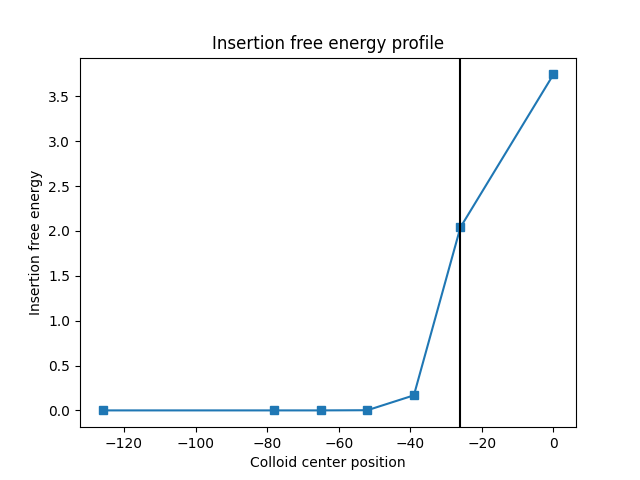

In [16]:
fig, ax = plt.subplots()

ax.plot(insertion_free_energy_data["pc"], insertion_free_energy_data["free_energy"], marker = "s")
pore_length = 52
ax.axvline(-pore_length/2, color='k')

ax.set_xlabel("Colloid center position")
ax.set_ylabel("Insertion free energy")
ax.set_title("Insertion free energy profile")

Cylindrical particle volume projection matrix:
[[ 3.14159265  3.14159265  3.14159265  3.14159265  3.14159265  3.14159265]
 [ 9.42477796  9.42477796  9.42477796  9.42477796  9.42477796  9.42477796]
 [15.70796327 15.70796327 15.70796327 15.70796327 15.70796327 15.70796327]]
Cylindrical particle surface projection matrix:
[[ 3.14159265  0.          0.          0.          0.          3.14159265]
 [ 9.42477796  0.          0.          0.          0.          9.42477796]
 [34.55751919 18.84955592 18.84955592 18.84955592 18.84955592 34.55751919]]


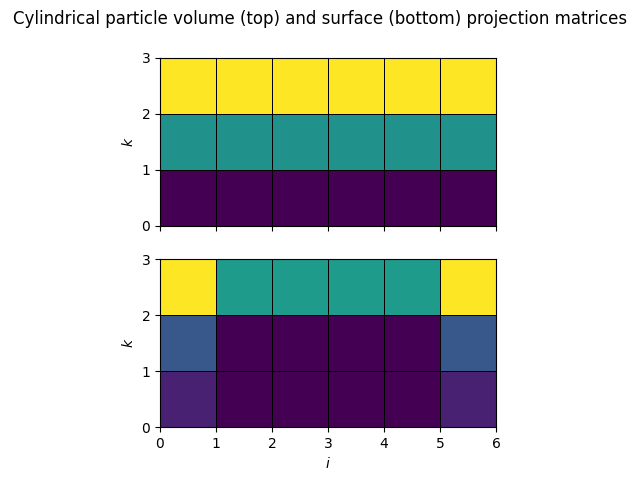

In [17]:
def cylinder_r0_kernel(radius:int, height:int = None):
    if height is None:
        height = radius*2
    r = np.arange(radius)
    volume_r = np.pi*(2*r+1)
    volume = np.tile(volume_r, (height,1)).T
    surface = np.zeros_like(volume)

    surface[:, 0] = surface[:,-1] = volume_r
    surface[-1,:] =surface[-1,:] + 2*np.pi*radius
    return volume, surface

volume, surface = cylinder_r0_kernel(3, 6)
print("Cylindrical particle volume projection matrix:")
print(volume)
print("Cylindrical particle surface projection matrix:")
print(surface)

fig, ax = plt.subplots(nrows = 2, sharex = True)
# fig.set_size_inches(4.5,5)
ax[0].pcolormesh(volume, edgecolor = "black", linewidth = 0.7)
ax[1].pcolormesh(surface, edgecolor = "black", linewidth = 0.7)
ax[1].set_xticks(np.arange(0,7, 1))
ax[0].set_yticks(np.arange(0,4, 1))
ax[1].set_yticks(np.arange(0,4, 1))
ax[1].set_xlim(0,6)
ax[0].set_ylim(-0,3)
ax[1].set_ylim(-0,3)
ax[0].set_yticks(np.arange(0,4, 1))
ax[1].set_yticks(np.arange(0,4, 1))
ax[1].set_xlabel("$i$")
ax[0].set_ylabel("$k$")
ax[1].set_ylabel("$k$")

ax[0].set_aspect("equal", adjustable="box") 
ax[1].set_aspect("equal", adjustable="box") 

fig.suptitle("Cylindrical particle volume (top) and surface (bottom) projection matrices")
pass # to suppress matplotlib output

[0.67994881 0.        ]


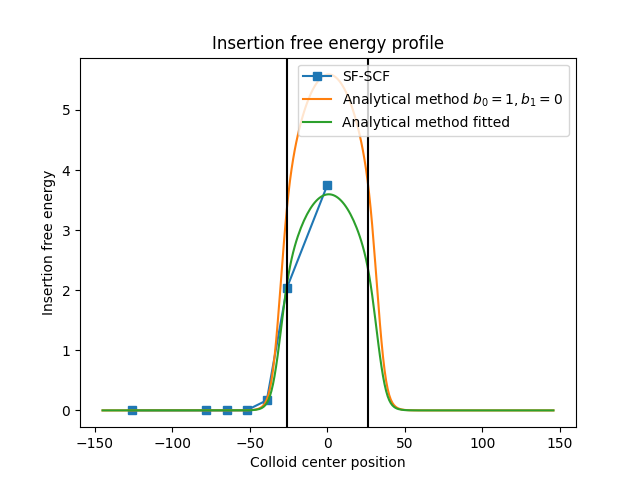

In [32]:
def gamma_model(chi_PS, chi_PC, phi, X):
    #Number of fitting parameters X can be expanded, but just two is already produce adequate results
    b0, b1 = X
    chi_crit = 6*np.log(5/6)
    phi_corrected = (b0 + b1*chi_PC)*phi
    chi_ads = chi_PC - chi_PS*(1-phi_corrected)
    gamma = (chi_ads - chi_crit)*phi_corrected/6
    return gamma

def Pi(phi, chi_PS):
    Pi_=-np.log(1-phi) - phi - chi_PS*phi**2
    return Pi_

def insertion_free_energy_cylinder(radius, phi_0, chi_PS, chi_PC, gamma_func, X_args):
    from scipy.signal import convolve
    volume, surface = cylinder_r0_kernel(radius)
    phi_0 = np.pad(phi_0[0:radius], ((0, 0),(radius,radius-1)))
    Pi_arr = Pi(phi_0, chi_PS)
    gamma_arr = gamma_func(chi_PS, chi_PC, phi_0, X_args)
    osmotic = convolve(Pi_arr, volume, 'valid')[0]
    surface = convolve(gamma_arr, surface, 'valid')[0]
    return osmotic+surface

def create_cost_function(colloid_diameter, colloid_positions, scf_insertion_fe, phi_0, chi_PS, chi_PC, gamma_model):
    def cost_function(X):
        FE = insertion_free_energy_cylinder(colloid_diameter//2, phi_0, chi_PS, chi_PC, gamma_model, X)
        position_in_array = colloid_positions + len(FE)//2
        residuals = scf_insertion_fe -  FE[position_in_array]
        return residuals
    return cost_function

cylindrical_colloid_diameter = 6
b0, b1 = 1, 0
insertion_free_energy_cylinder_analytical_no_fit =  insertion_free_energy_cylinder(cylindrical_colloid_diameter//2, phi_0, chi_PS = 0.6, chi_PC = 0, gamma_func=gamma_model, X_args=[b0, b1])

X0 = [1,0]
from scipy.optimize import least_squares
cost_function = create_cost_function(cylindrical_colloid_diameter, insertion_free_energy_data["pc"], insertion_free_energy_data["free_energy"], phi_0, chi_PS=0.6, chi_PC = 0, gamma_model=gamma_model)
X = least_squares(cost_function, X0).x
print(X)

b0, b1 = X
insertion_free_energy_cylinder_analytical_fit =  insertion_free_energy_cylinder(cylindrical_colloid_diameter//2, phi_0, chi_PS = 0.6, chi_PC = 0, gamma_func=gamma_model, X_args=[b0, b1])


fig, ax = plt.subplots()
ax.plot(insertion_free_energy_data["pc"], insertion_free_energy_data["free_energy"], marker = "s", label = "SF-SCF")
ax.plot(Z, insertion_free_energy_cylinder_analytical_no_fit, label="Analytical method $b_0=1, b_1=0$")
ax.plot(Z, insertion_free_energy_cylinder_analytical_fit, label="Analytical method fitted")
pore_length = 52
ax.axvline(-pore_length/2, color='k')
ax.axvline(+pore_length/2, color='k')

ax.set_xlabel("Colloid center position")
ax.set_ylabel("Insertion free energy")
ax.set_title("Insertion free energy profile")
ax.legend(loc = "upper right")